In [1]:
%matplotlib inline

import numpy as np

from triqs.plot.mpl_interface import plt
from triqs_tprf.tight_binding import create_square_lattice


Starting run with 1 MPI rank(s) at : 2020-08-18 10:41:49.147374


In [2]:
plt.style.use('notebook.mplstyle')

# Linearized Eliashberg equation on the attractive Hubbard model

A simple example for the usage of the linearized Eliashberg equation is the attractive Hubbard model on a square lattice.
It is not only fast and simple to setup, but the particle-hole symmetry of the Hubbard model also serves as a benchmark for the correctness of such a calculation.

In the following we will first introduce the Hubbard model and present the semi particle-hole transformation and its usage.
Then we will show how to solve the linearized Eliashberg equation for this model to find the superconducting phase transition using TRIQS and TPRF routines.

If you want a more detailed study of this problem, checkout this [notebook](https://github.com/TRIQS/tprf/blob/eliashberg/benchmark/eliashberg/particle_hole_transformation/PHT_Hubbard_Model.ipynb).

## Hubbard model on a square lattice

The particle-hole symmetric Hamiltonian for the Hubbard model is given by

$$
H=-t \sum_{\langle j, l\rangle \sigma}\left(c_{j \sigma}^{\dagger} c_{l \sigma}+c_{l \sigma}^{\dagger} c_{j \sigma}\right)+U \sum_{j}\left(n_{j \uparrow}-\frac{1}{2}\right)\left(n_{j \downarrow}-\frac{1}{2}\right)-\mu \sum_{j}\left(n_{j \uparrow}+n_{j \downarrow}\right)\,,
$$

here $c_{j\sigma}^{\dagger}$ creates an electron on site $j$ with spin $\sigma$ while $c_{j\sigma}$ destroys such an electron, further the operator $n_{j\sigma}$ count the number of electrons on site $j$ with spin $\sigma$.

The first term describes the kinetic energy of the electrons, which can be interpreted as an electron with spin $\sigma$ *hopping* from site $l$ to site $j$ and vice versa.
Here the angular braket under the sum means that we only take *hopping* terms between neighboring lattice sites into account and the energy that is gained by such a *hopping* process is given by $t$.

The second term describes the repulsive interaction between the electrons.
This repulsion is crudely approximated in the Hubbard model in the sense, that electrons only *see* each other if they occupy the same lattice site.
The energy that is needed to have a lattice site doubly occupied is given by $U$.

The last term describes the filling of the lattice via an energy offset by the chemical potential $\mu$.

The Hubbard model is therefore defined by the parameters $t$, $U$ and $\mu$, but we also need to know the temperature $T$ at which we shall observe the Hubbard model.
We will record these parameters using the `ParameterCollection` class of `triqs_tprf.ParameterCollection` module.

In [3]:
from triqs_tprf.ParameterCollection import ParameterCollection

hubbard = ParameterCollection(   # -- Model Parameter
                                 norb=1, # Number of orbitals.
                                 t=1.0, # Hopping to nearest neighbor
                                 U=1.0, # Strength of the on-site interaction
                                 mu=0.0, # Chemical potential determining the filling.
                                 T=1000, # Temperature.
                                 spin=False, # Treat indices only for orbital character.
    
                                 # -- Technical parameter
                                 nk=32, # Number of points in one dimension considered in the Brillouin zone.
                                 nw=50, # Number of Matsubara points in positive dimension.
                                        )
hubbard

T = 1000
U = 1.0
mu = 0.0
nk = 32
norb = 1
nw = 50
spin = False
t = 1.0

### Semi particle-hole transformation

The Hubbard model with only nearest neighbor hopping inhibts a useful semi particle-hole symmetry, which we will present without any rigorous derivations.

First off, a bipartite lattice can be subdivided into two sublattices for which every lattice site on one of them only has neighboring sites from the other sublattice. This is the case for our square lattice.
With this knowledge we can define the particle-hole transformation (PHT) for the creation and annihilation operators as 

$$
c^\dagger_{j \sigma} \xrightarrow{\mathrm{PHT}} (-1)^{j} d_{j \sigma} \,,\quad
\mathrm{and}\quad
c_{j \sigma} \xrightarrow{\mathrm{PHT}}(-1)^{j}d_{j \sigma}^{\dagger}\,,\\
$$

where $j$ is either $0$ for one sublattice and $1$ for the other.

If we use the PHT only on one spin specices it is called a semi particle-hole transformation (SPHT).
This means

$$
c_{j \uparrow}^{\dagger} \xrightarrow{\mathrm{SPHT}} d_{j \uparrow}^{\dagger}\quad\mathrm{and}\quad
c_{j \uparrow} \xrightarrow{\mathrm{SPHT}} d_{j \uparrow}\\
c_{j \downarrow}^{\dagger} \xrightarrow{\mathrm{SPHT}} (-1)^j d_{j \downarrow}\quad\mathrm{and}\quad
c_{j \downarrow} \xrightarrow{\mathrm{SPHT}} (-1)^j d_{j \downarrow}^{\dagger}\,,
$$

and for the number operators

$$
n_{j \uparrow}\xrightarrow{\mathrm{SPHT}} \tilde{n}_{j \uparrow}
\quad\mathrm{and}\quad
n_{j \downarrow} \xrightarrow{\mathrm{SPHT}} 1-\tilde{n}_{j \downarrow}\,.
$$

One can convince themselves, that the kinetic part of the Hubbard model on a square lattice with only nearest neighbor hopping is invariant under a SPHT.
The interaction term on the other hand is not and changes sign

$$
\left(n_{j \uparrow}-\frac{1}{2}\right)\left(n_{j \downarrow}-\frac{1}{2}\right) \xrightarrow{\mathrm{SPHT}}
-\left(\tilde{n}_{j \uparrow} - \frac{1}{2}\right)\left(\tilde{n}_{j \downarrow}-\frac{1}{2}\right)\,.
$$

Therefore the SPHT maps the repulsive Hubbard model with $U$ to the attractive one with $-U$.
Additionally to that, if our Hubbard model is not a half-filling, the chemical potential term is also not invariant under a SPHT

$$
n_{j \uparrow}+n_{j \downarrow} \xrightarrow{\mathrm{SPHT}}
1 + \left(\tilde{n}_{j \uparrow}-\tilde{n}_{j \downarrow}\right)\,,
$$

and transforms into a Zeeman term.

To summarize the SPHT maps the Hubbard Hamiltonian with interaction strength $U$ and chemical potential $\mu$ to a Hubbard Hamiltonian with interaction strength $-U$, a chemical potential of $0$ and an additional Zeeman term of strength $\mu$.
If we therefore calculate an observable $A$ in the attractive Hubbard model we know the observable $B\xleftarrow{\mathrm{SPHT}}A$ in the repulsive one.

For example, the in-plane antiferromagnetic (AFM) phase of the repulsive model is connected to the superconducting (SC) phase in the attractive one, as can be seen by using the SPHT on the ladder operators of the spin

$$
S^+_j = S^x_j + iS^y_j = c_{j \uparrow}^{\dagger}c_{j \downarrow} \xrightarrow{\mathrm{SPHT}} (-1)^j d_{j \uparrow}^{\dagger}d_{j \downarrow}^{\dagger} = \tilde{\Delta}^{\dagger}\,,\\
S^-_j = S^x_j - iS^y_j = c_{j \downarrow}^{\dagger}c_{j \uparrow} \xrightarrow{\mathrm{SPHT}} (-1)^j d_{j \downarrow}d_{j \uparrow} = \tilde{\Delta}\,.
$$

The $x$- and $y$-components of the spin operator are transformed to the complex superconducting oder parameter with a phase factor.
This means, that if we find a staggered in-plane spin phase in the repulsive model at some $U$, we will see a homogeneous superconducting phase at $-U$.

The following plot shows this symmetry in a T-U phase diagram, which was previously calculated [here](https://github.com/TRIQS/tprf/blob/eliashberg/benchmark/eliashberg/particle_hole_transformation/PHT_Hubbard_Model.ipynb).

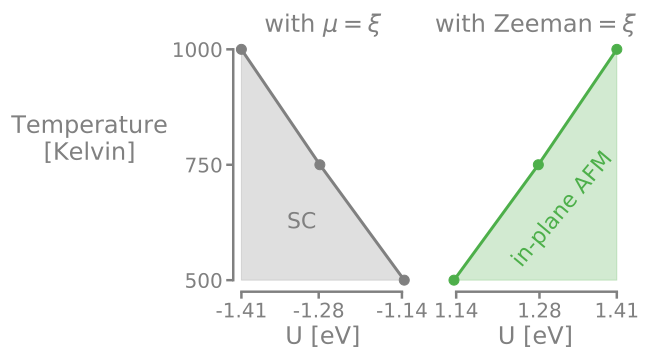

In [4]:
from IPython.core.display import SVG

SVG(filename='./plots/SPHT_hubbard_phase_diagram.svg')

The right hand side of the phase diagram was calculated using an attractive Hubbard model at half-filling, i.e. $\mu=0.0$, with an additional Zeeman term of strength $\xi$.
The phase boundary was then calculated using the random phase approximation (RPA), i.e. using a frequency independent and local vertex $U$, to calculate $\langle S^xS^x \rangle$ and increasing $U$ until divergence.
For details on how to use TPRF for that see this [tutorial](Square lattice susceptibility.ipynb#Random-phase-approximation-(RPA)).

The left hand side of the phase diagram was calculated using an repulsive Hubbard model with $\mu=\xi$, i.e. the SPHT mapping of the right hand side model.
Then the linearized Eliashberg equation was solved for this model for various interaction strengths until the superconducting phase transition was found.

## Solving the linearized Eliashberg equation

The linearized Eliashberg equation is given in a very simplified form by

$$
\lambda\Delta = \Lambda \Delta\,,
$$

where $\Delta$ is a gap function and $\lambda$ the largest eigenvalue of the matrix $\Lambda$.
Here $\Lambda$ is the product of the particle-particle vertex $\Gamma$ and the Green's function $G$.
If $\lambda=1$ a phase transition to a superconducting state is found.
For further information see the documentation [here](../theory/eliashberg.rst).

To solve it in the same order as the RPA we need the non-interacting Green's function $G^{(0)}$ and the (singlet) particle-particle vertex $\Gamma$ is approximated by a fequency independent and local vertex $2U$.

First we setup our model by using previously established `ParameterCollection` `hubbard` as a template and alter it to the parameters of the repulsive Hubbard model.
To do this use its method `alter` and supply the parameters that shall be changed as keywords.
We set the chemical potential to $\mu=\xi$ and the interaction strength to $U=-1.41$, which is close to the superconducting phase boundary for $T=1000\,\mathrm{K}$.

In [5]:
xi = 0.1

repl_hubbard = hubbard.alter(mu=xi, U=-1.41)
repl_hubbard

T = 1000
U = -1.41
mu = 0.1
nk = 32
norb = 1
nw = 50
spin = False
t = 1.0

To construct a representation of the kinetic part of the Hubbard model use the `create_square_lattice` function of the `triqs_tprf.tight_binding` module.
Give it as keywords the number of orbitals `norb` and the hopping energy `t`, which can comfortably be accessed from `repl_hubbard`.
It returns a `TBLattice` object.

In [6]:
from triqs_tprf.tight_binding import create_square_lattice

H = create_square_lattice(norb=repl_hubbard.norb, t=repl_hubbard.t)
type(H)

triqs_tprf.tight_binding.TBLattice

To get the dispersion relation, use its member function `fourier` and enter a mesh obtained using the other member function `get_kmesh` on the Brillouin zone as a tuple.
It returns the dispersion relation stored as a `Gf` object.

In [7]:
e_k = H.fourier(H.get_kmesh(n_k=(repl_hubbard.nk, repl_hubbard.nk, 1)))
type(e_k)

triqs.gf.gf.Gf

With the dispersion relation we can construct the non-interacting Green's function.
To do this first create a `MeshImFreq` object with a fermionic statistic and the wished inverse temperature $\beta$ and number of points.
Then use the `lattice_dyson_g0_wk` function of the `triqs_tprf.lattice` module and supply it with the dispersion relation, the `MeshImFreq` object and a chemical potential.
This yields the non-interacting Green's function as a `Gf` object.
(You can use the `temperature_to_beta` function of the `triqs_tprf.utilities` to calculate the inverse temperature in $\mathrm{eV}$ from the temperature in $\mathrm{Kelvin}$.)

In [8]:
from triqs_tprf.lattice import lattice_dyson_g0_wk
from triqs.gf import MeshImFreq
from triqs_tprf.utilities import temperature_to_beta

beta = temperature_to_beta(repl_hubbard.T)
wmesh = MeshImFreq(beta=beta, S='Fermion', n_max=repl_hubbard.nw)
g0_wk = lattice_dyson_g0_wk(mu=repl_hubbard.mu, e_k=e_k, mesh=wmesh)
type(g0_wk)

triqs.gf.gf.Gf

The particle-particle vertex $\Gamma$ in this case must be manually created.
To do this first create a `MeshImFreq` in the same manner as before, but this time with a bosonic statistic.
Then use this `MeshImFreq` and combine it with the momentum mesh of the non-interacting Green's function to create a `MeshProduct` object.
Use this `MeshProduct` object to create a `Gf` object with a `target_shape` that corresponds to a two-particle object, e.g. `(1, 1, 1, 1)`.
Then overwrite its data to be constant to $U$.

In [9]:
from triqs.gf import Gf, MeshProduct

wmesh_boson = MeshImFreq(beta=temperature_to_beta(repl_hubbard.T), S='Boson', n_max=repl_hubbard.nw)
wmesh_boson_kmesh = MeshProduct(wmesh_boson, g0_wk.mesh[1])
gamma_pp = Gf(mesh=wmesh_boson_kmesh, target_shape=g0_wk.target_shape*2)
gamma_pp.data[:] = 2*repl_hubbard.U

With this we have all ingredients for the linearized Eliashberg equation.
To solve it use the `solve_eliashberg` function of the `triqs_tprf.eliashberg` module and supply it with the particle-particle vertex and the non-interacting Green's function.
It returns the eigenvalues and eigenvectors, i.e. the gap functions.

The returned maximum eigenvalue is $\lambda \approx 1$ as expected, because we are close to the phase boundary.

In [10]:
from triqs_tprf.eliashberg import solve_eliashberg

Es, eigen_modes = solve_eliashberg(gamma_pp, g0_wk)
Es[0]

0.9999705817306739